In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import umap.umap_ as umap
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from IPython.display import display



In [2]:
"""Note: Cái này em làm lại từ đầu thử nên em drop dup - missing - one hot dữ liệu categorical - 
xử lý numerical (log-trans + robust scaler + xóa nhiễu)
- feature engineering (extract xóa cột tương quan trên 75, giữ cột có variance cao hơn + pca 5 chiều)"""

'Note: Cái này em làm lại từ đầu thử nên em drop dup - missing - one hot dữ liệu categorical - \nxử lý numerical (log-trans + robust scaler + xóa nhiễu)\n- feature engineering (extract xóa cột tương quan trên 75, giữ cột có variance cao hơn + pca 5 chiều)'

In [3]:
# Tải dữ liệu
try:
    df = pd.read_csv('Wholesale customers data.csv')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'Wholesale customers data.csv'.")
    exit()

print("5 dòng dữ liệu đầu tiên:")
display(df.head(5))

# Kiểm tra và loại bỏ dòng trùng lặp
before_dup = df.shape[0]
df = df.drop_duplicates()
after_dup = df.shape[0]
print(f"\nSố dòng trùng lặp đã bị xóa: {before_dup - after_dup}")

# Kiểm tra và xử lý giá trị thiếu
missing_counts = df.isnull().sum()
print("\nSố giá trị thiếu trên mỗi cột:\n", missing_counts)

if missing_counts.sum() > 0:
    df = df.dropna()
    print("\nĐã xóa các hàng chứa giá trị thiếu.")
    print(f"Kích thước dữ liệu sau khi xử lý thiếu: {df.shape}")

# Reset index để đảm bảo tính nhất quán
df = df.reset_index(drop=True)

5 dòng dữ liệu đầu tiên:


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185



Số dòng trùng lặp đã bị xóa: 0

Số giá trị thiếu trên mỗi cột:
 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [4]:
# Chuyển đổi các cột phân loại sang kiểu string để chuẩn bị one-hot
cat_cols = ['Channel', 'Region']
df[cat_cols] = df[cat_cols].astype(str)

# Thực hiện one-hot encoding, drop_first=True để tránh đa cộng tuyến
df_dummies = pd.get_dummies(df[cat_cols], prefix=cat_cols, drop_first=True)

# Tách các cột số để xử lý
num_cols = df.select_dtypes(include=np.number).columns.tolist()
df_num = df[num_cols]

print("Các cột được tạo ra từ One-Hot Encoding:", df_dummies.columns.tolist())


Các cột được tạo ra từ One-Hot Encoding: ['Channel_2', 'Region_2', 'Region_3']


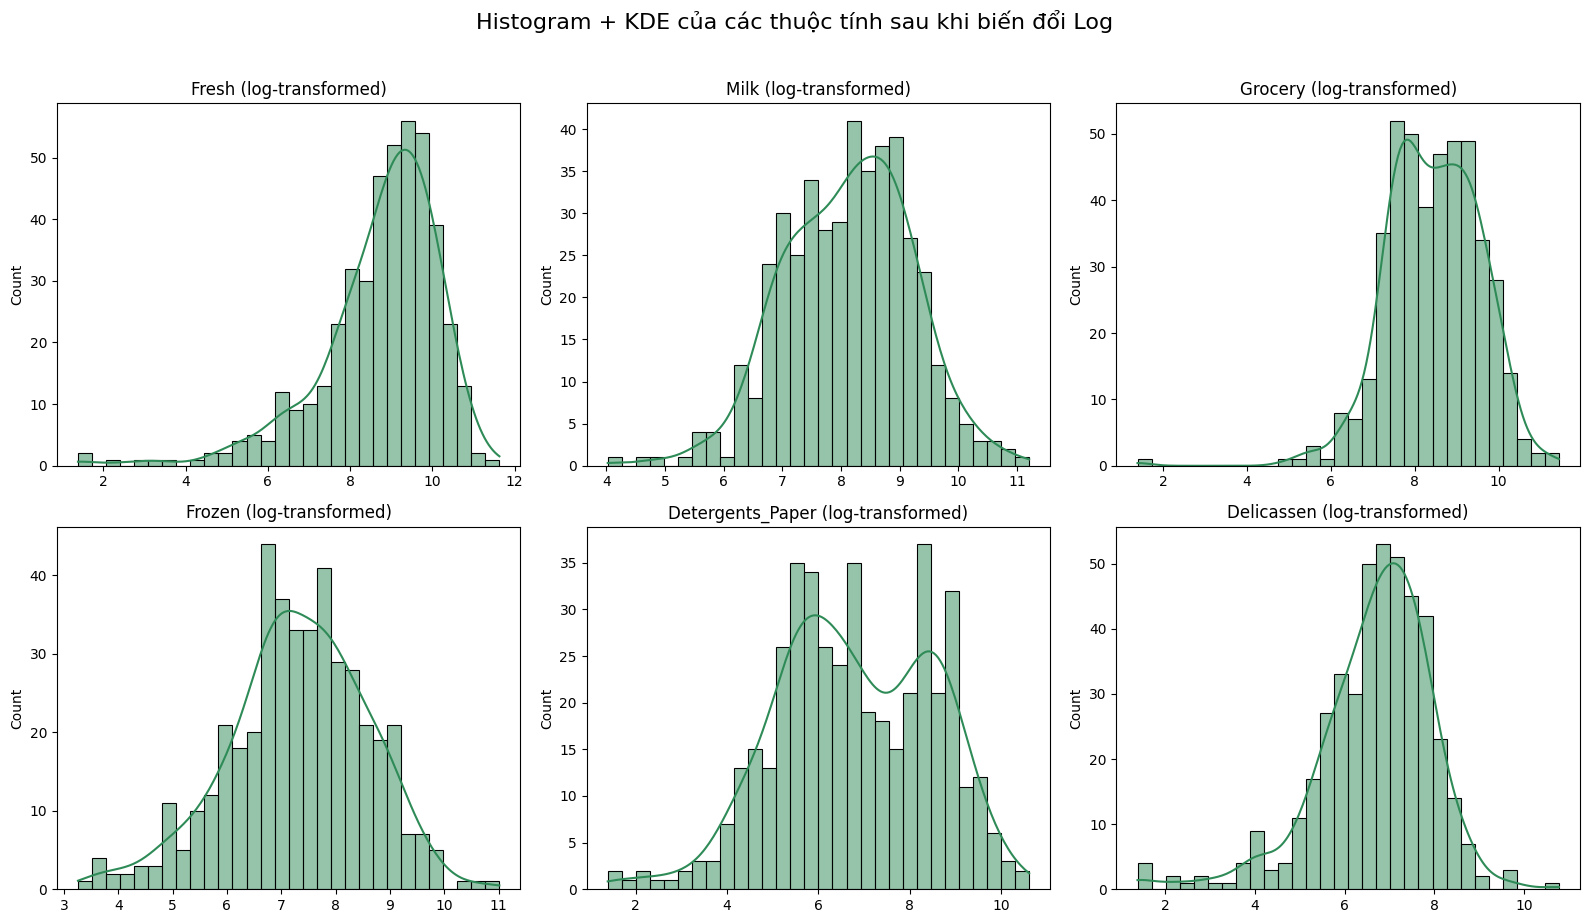

In [5]:
# Các cột số cần biến đổi log
cols_to_log = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Áp dụng log(x+1) để tránh log(0)
df_log_transformed = df_num.copy()
df_log_transformed[cols_to_log] = np.log1p(df_num[cols_to_log])

# Vẽ biểu đồ histogram để xem phân phối sau khi biến đổi log
plt.figure(figsize=(16, 9))
plt.suptitle("Histogram + KDE của các thuộc tính sau khi biến đổi Log", y=1.02, fontsize=16)

for i, col in enumerate(cols_to_log, 1):
    ax = plt.subplot(2, 3, i)
    sns.histplot(df_log_transformed[col], kde=True, bins=30, color='seagreen')
    ax.set_title(f"{col} (log-transformed)")
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

In [6]:
# Khởi tạo Scaler
scaler = RobustScaler()

# Scale các cột đã biến đổi log
scaled_array = scaler.fit_transform(df_log_transformed)
df_scaled = pd.DataFrame(scaled_array, columns=cols_to_log)

# Kết hợp dữ liệu số đã scale và dữ liệu phân loại đã one-hot
df_preprocessed = pd.concat([df_scaled, df_dummies], axis=1)

print("5 dòng đầu của dữ liệu đã được tiền xử lý hoàn chỉnh:")
display(df_preprocessed.head())

print(f"\nKích thước dữ liệu cuối cùng để phân tích: {df_preprocessed.shape}")

5 dòng đầu của dữ liệu đã được tiền xử lý hoàn chỉnh:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_2,Region_2,Region_3
0,0.236027,0.633665,0.289970,-1.252532,0.435415,0.218358,True,False,True
1,-0.110429,0.643905,0.437195,0.091831,0.511868,0.407917,True,False,True
2,-0.172651,0.574176,0.300061,0.290501,0.535928,1.402554,True,False,True
3,0.263246,-0.717716,-0.074555,0.916071,-0.174744,0.412425,False,False,True
4,0.579134,0.258743,0.259202,0.601719,0.285389,1.125309,True,False,True



Kích thước dữ liệu cuối cùng để phân tích: (440, 9)


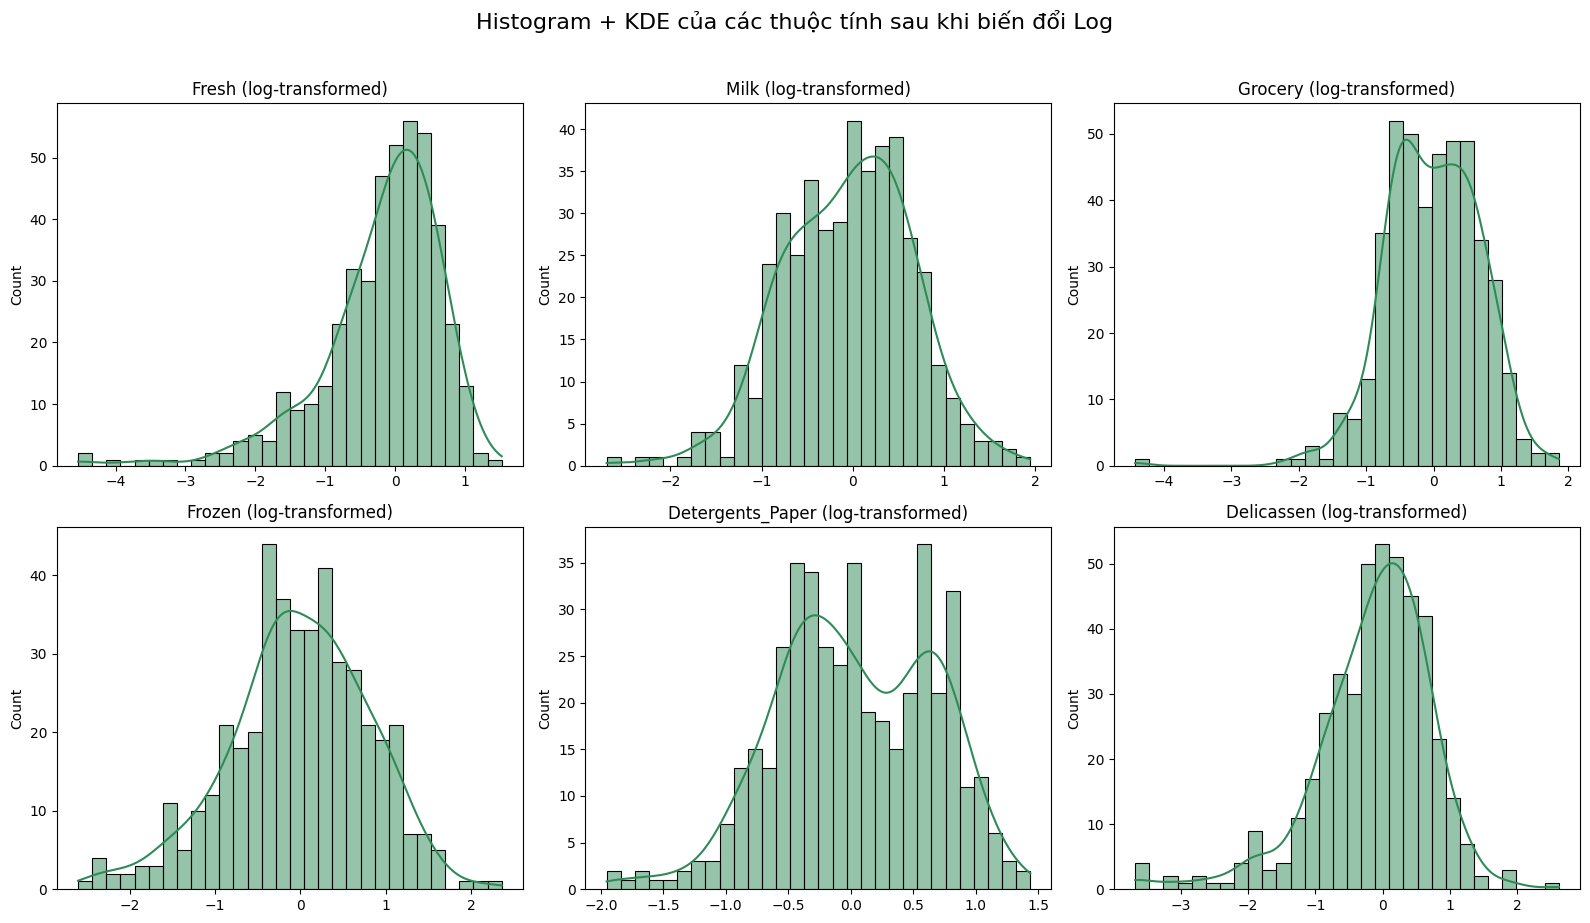

In [7]:
plt.figure(figsize=(16, 9))
plt.suptitle("Histogram + KDE của các thuộc tính sau khi biến đổi Log", y=1.02, fontsize=16)

for i, col in enumerate(cols_to_log, 1):
    ax = plt.subplot(2, 3, i)
    sns.histplot(df_preprocessed[col], kde=True, bins=30, color='seagreen')
    ax.set_title(f"{col} (log-transformed)")
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

In [8]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination='auto', # hoặc 0.05, 0.1, ...
    random_state=42
)
predictions = iso_forest.fit_predict(df_preprocessed)

# Đếm số lượng outlier bị phát hiện
n_outliers = (predictions == -1).sum()
print(f"Số outlier bị phát hiện bởi Isolation Forest: {n_outliers}")

# Tạo một DataFrame mới không chứa outlier
df_filtered = df_preprocessed[predictions == 1].reset_index(drop=True)

print(f"Kích thước dữ liệu ban đầu (đã tiền xử lý): {df_preprocessed.shape}")
print(f"Kích thước dữ liệu sau khi loại bỏ outlier: {df_filtered.shape}")

df_preprocessed = df_filtered.copy()

Số outlier bị phát hiện bởi Isolation Forest: 94
Kích thước dữ liệu ban đầu (đã tiền xử lý): (440, 9)
Kích thước dữ liệu sau khi loại bỏ outlier: (346, 9)


Ma trận tương quan TRƯỚC khi lựa chọn đặc trưng


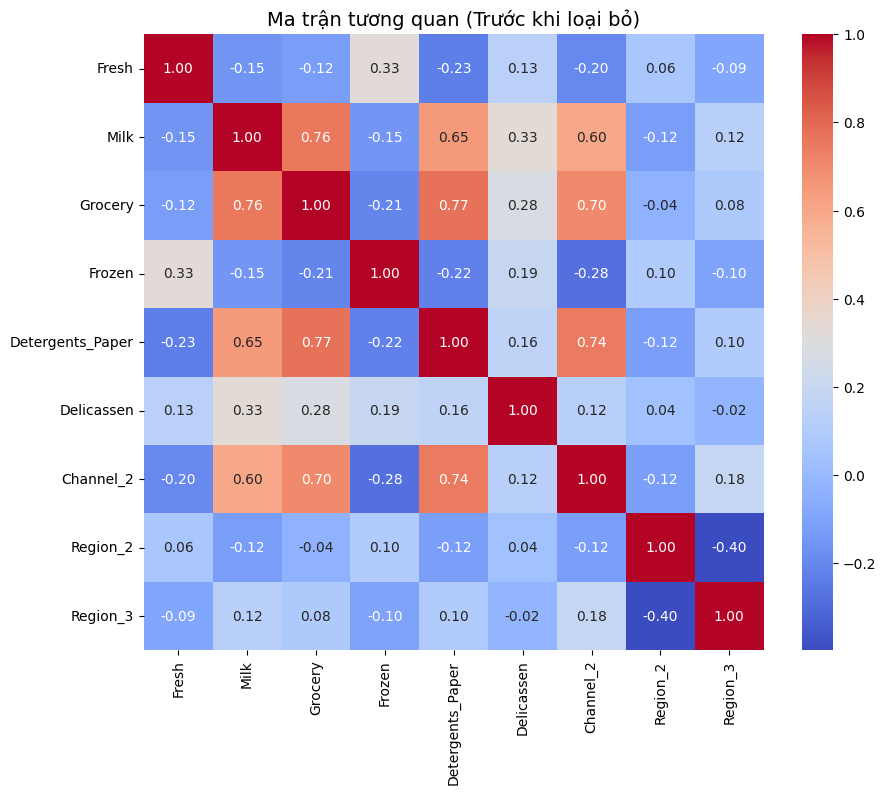


Bắt đầu quá trình lựa chọn đặc trưng
- Giữa 'Grocery' và 'Milk', loại bỏ 'Grocery' (phương sai thấp hơn).

Danh sách các cột bị loại bỏ: ['Grocery']

Kích thước dữ liệu ban đầu: (346, 9)
Kích thước dữ liệu sau khi lựa chọn đặc trưng: (346, 8)

Ma trận tương quan SAU khi lựa chọn đặc trưng


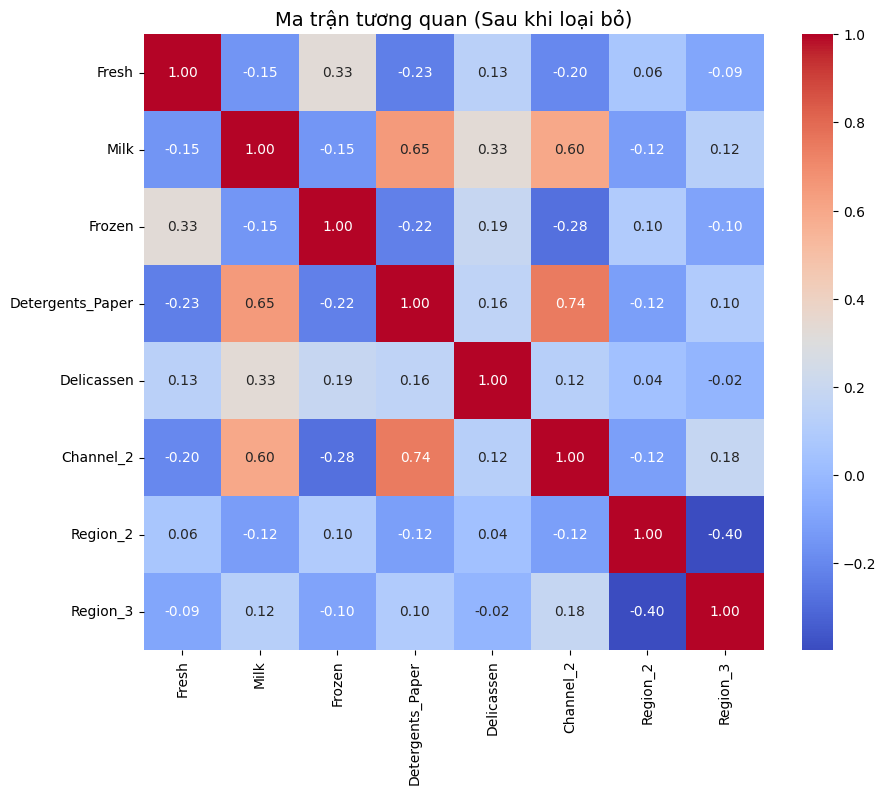

In [9]:
# 1. Vẽ ma trận tương quan ban đầu để so sánh trước và sau
print("Ma trận tương quan TRƯỚC khi lựa chọn đặc trưng")
plt.figure(figsize=(10, 8))
sns.heatmap(df_preprocessed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Ma trận tương quan (Trước khi loại bỏ)", fontsize=14)
plt.show()

# 2. Thực hiện logic lựa chọn đặc trưng
print("\nBắt đầu quá trình lựa chọn đặc trưng")

# Đặt ngưỡng tương quan
correlation_threshold = 0.75

# Tính toán ma trận tương quan tuyệt đối
corr_matrix = df_preprocessed.corr().abs()

# Lấy ma trận tam giác trên để tránh kiểm tra các cặp lặp lại (A,B) và (B,A)
# k=1 để loại bỏ đường chéo chính (tương quan của một biến với chính nó)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Dùng một set để lưu tên các cột cần loại bỏ (set tự động xử lý trùng lặp)
columns_to_drop = set()

# Duyệt qua từng cột trong ma trận tam giác trên
for column in upper_triangle.columns:
    # Tìm các cột có tương quan cao (> ngưỡng) với cột hiện tại
    highly_correlated_features = upper_triangle.index[upper_triangle[column] > correlation_threshold].tolist()

    # Nếu có cột tương quan cao, tiến hành so sánh phương sai
    if highly_correlated_features:
        for other_feature in highly_correlated_features:
            # Bỏ qua nếu một trong hai cột đã nằm trong danh sách loại bỏ
            if column in columns_to_drop or other_feature in columns_to_drop:
                continue

            # So sánh phương sai của cặp đặc trưng
            variance_column = df_preprocessed[column].var()
            variance_other_feature = df_preprocessed[other_feature].var()

            # Giữ lại cột có phương sai cao hơn
            if variance_column < variance_other_feature:
                columns_to_drop.add(column)
                print(f"- Giữa '{column}' và '{other_feature}', loại bỏ '{column}' (phương sai thấp hơn).")
            else:
                columns_to_drop.add(other_feature)
                print(f"- Giữa '{column}' và '{other_feature}', loại bỏ '{other_feature}' (phương sai thấp hơn).")

# Chuyển set thành list để sử dụng với hàm drop()
dropped_cols_list = list(columns_to_drop)

if dropped_cols_list:
    print(f"\nDanh sách các cột bị loại bỏ: {dropped_cols_list}")
    # Tạo DataFrame mới sau khi đã loại bỏ các cột
    df_feature_selected = df_preprocessed.drop(columns=dropped_cols_list)
else:
    print("\nKhông có cột nào bị loại bỏ. Dữ liệu được giữ nguyên.")
    df_feature_selected = df_preprocessed.copy()

print(f"\nKích thước dữ liệu ban đầu: {df_preprocessed.shape}")
print(f"Kích thước dữ liệu sau khi lựa chọn đặc trưng: {df_feature_selected.shape}")

# 3. Vẽ lại ma trận tương quan sau khi đã loại bỏ các cột
print("\nMa trận tương quan SAU khi lựa chọn đặc trưng")
plt.figure(figsize=(10, 8))
sns.heatmap(df_feature_selected.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Ma trận tương quan (Sau khi loại bỏ)", fontsize=14)
plt.show()

df_preprocessed = df_feature_selected.copy()

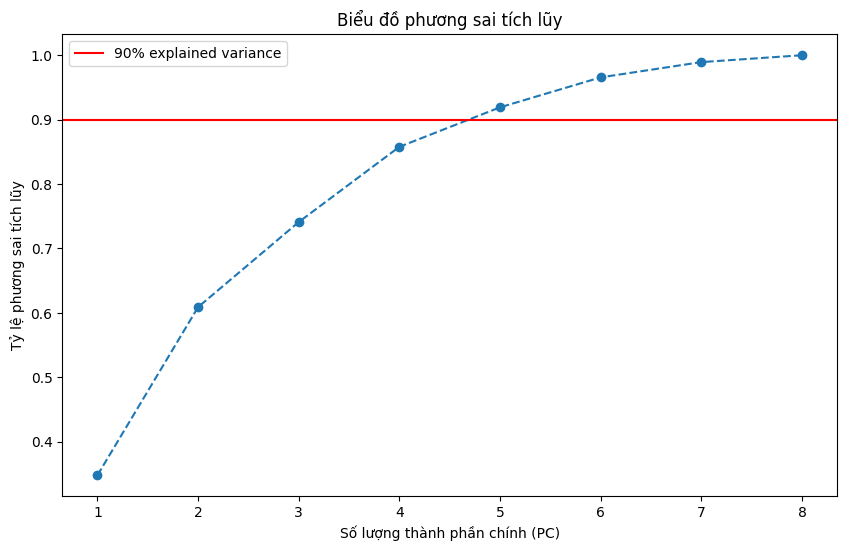

Phương sai được giải thích bởi 5 thành phần: 0.9191

5 dòng đầu của dữ liệu sau khi giảm chiều:


,PC1,PC2,PC3,PC4,PC5
0,-1.377338,0.236725,0.996473,-0.072331,0.108744
1,-0.759879,0.911657,-0.052825,-0.214680,0.133118
2,-0.666765,1.618517,-0.067168,0.467240,0.177515
3,1.076990,0.411145,-0.193493,0.225036,0.258858
4,0.070651,1.555742,0.317372,0.045827,0.227866


In [ ]:
'''# Áp dụng PCA để xác định số chiều cần giữ lại
pca = PCA(random_state=42)
pca.fit(df_preprocessed)

# Tính toán phương sai tích lũy
explained_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_ratio)

# Biểu đồ phương sai tích lũy (Scree Plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Số lượng thành phần chính (PC)")
plt.ylabel("Tỷ lệ phương sai tích lũy")
plt.title("Biểu đồ phương sai tích lũy")
# Thêm đường kẻ ngang tại 90% hoặc 95% để dễ xác định
plt.axhline(y=0.90, color='r', linestyle='-', label='90% explained variance')
plt.legend()
plt.show()

# Dựa vào biểu đồ, chọn số thành phần chính. Ví dụ, 4 thành phần.
n_components = 5
pca_final = PCA(n_components=n_components, random_state=42)
df_pca = pd.DataFrame(
    pca_final.fit_transform(df_preprocessed),
    columns=[f"PC{i}" for i in range(1, n_components + 1)]
)

print(f"Phương sai được giải thích bởi {n_components} thành phần: {np.sum(pca_final.explained_variance_ratio_):.4f}")
print("\n5 dòng đầu của dữ liệu sau khi giảm chiều:")
display(df_pca.head())'''

# Bỏ do mất thông tin

Đang thực hiện giảm chiều bằng PCA để trực quan hóa...


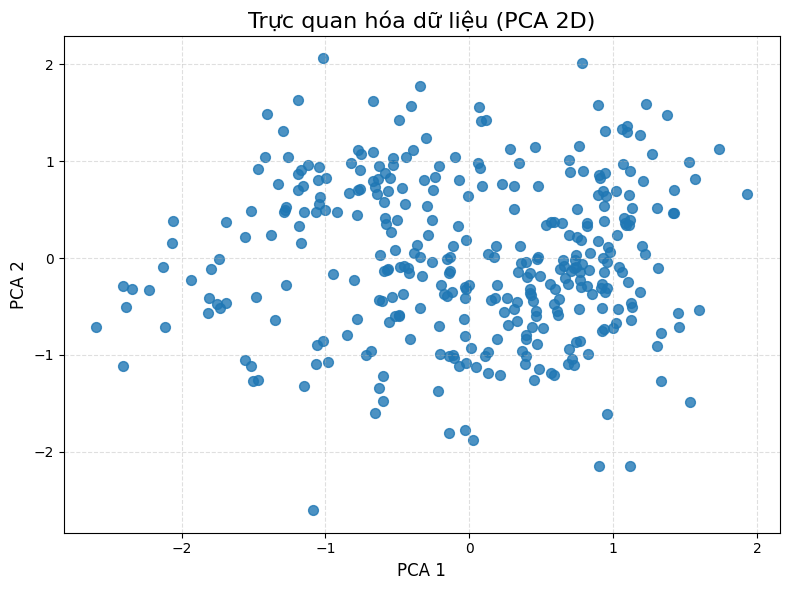

In [ ]:
# Trực quan dataset sau khi tiền xử lý lên 2D
pca_2d = PCA(n_components=2, random_state=42)
data_pca_2d = pca_2d.fit_transform(df_preprocessed)

print("Đang thực hiện giảm chiều bằng PCA để trực quan hóa...")

# Vẽ scatter 
plt.figure(figsize=(8, 6))
plt.scatter(
    data_pca_2d[:, 0],
    data_pca_2d[:, 1],
    c='tab:blue',   
    s=50,
    alpha=0.8
)
plt.title("Trực quan hóa dữ liệu (PCA 2D)", fontsize=16)
plt.xlabel("PCA 1", fontsize=12)
plt.ylabel("PCA 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


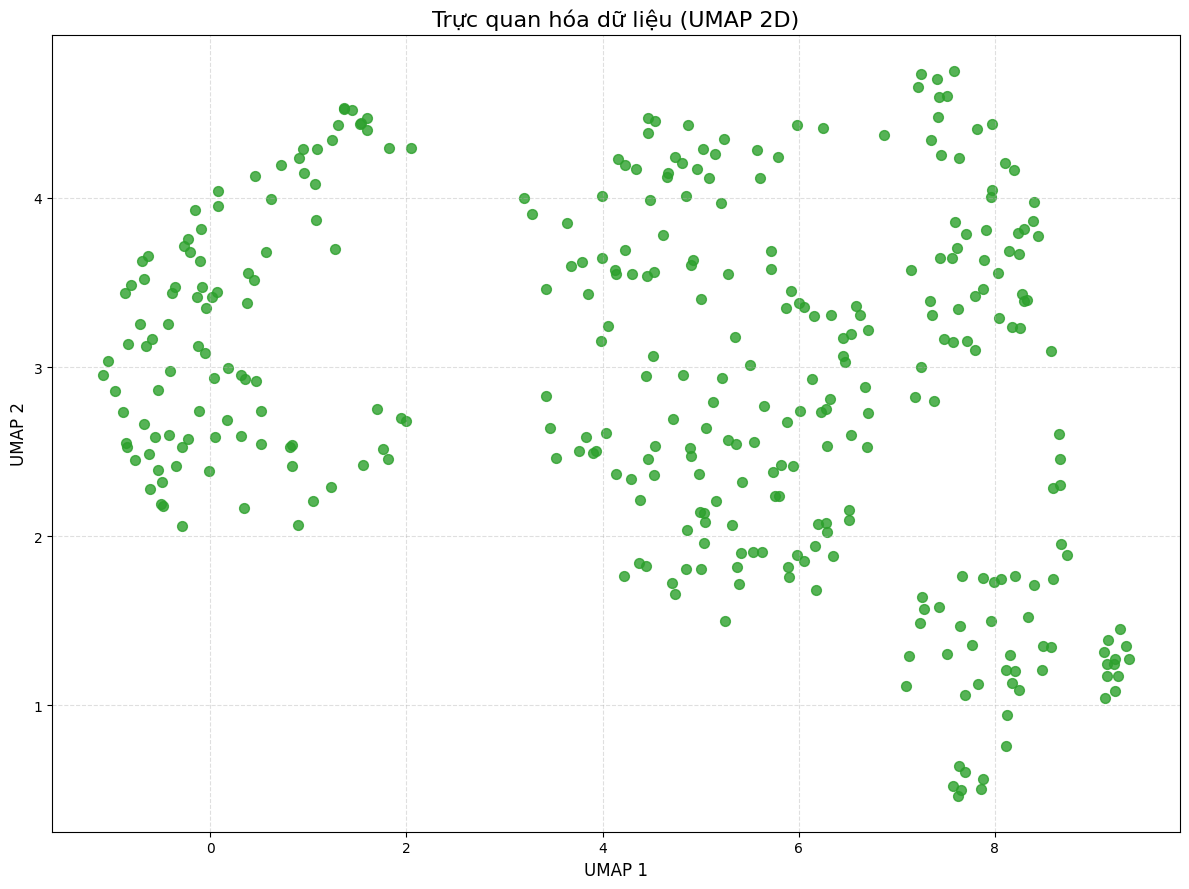

In [ ]:
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)
embedding = reducer.fit_transform(df_preprocessed)

# Vẽ scatter
plt.figure(figsize=(12, 9))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c='tab:green',
    s=50,
    alpha=0.8
)
plt.title("Trực quan hóa dữ liệu (UMAP 2D)", fontsize=16)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# Cluster trên dataset tiền xử lý df_preprocessed
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=8,
    min_samples=5,
    metric='euclidean',
    gen_min_span_tree=True
)

clusterer.fit_predict(df_preprocessed)
labels = clusterer.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Số cụm được tìm thấy (không tính nhiễu): {n_clusters}")

Số cụm được tìm thấy (không tính nhiễu): 4


c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21464\3154665490.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Đang trực quan hóa kết quả HDBSCAN trên PCA...


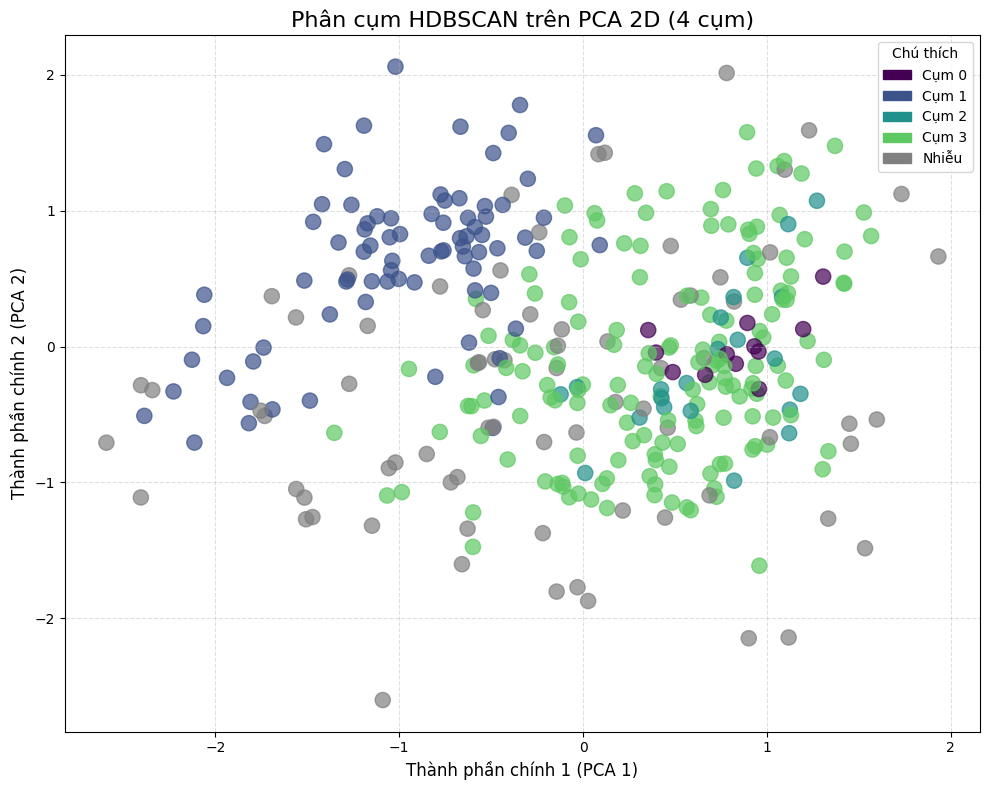

Đang trực quan hóa kết quả HDBSCAN trên UMAP...


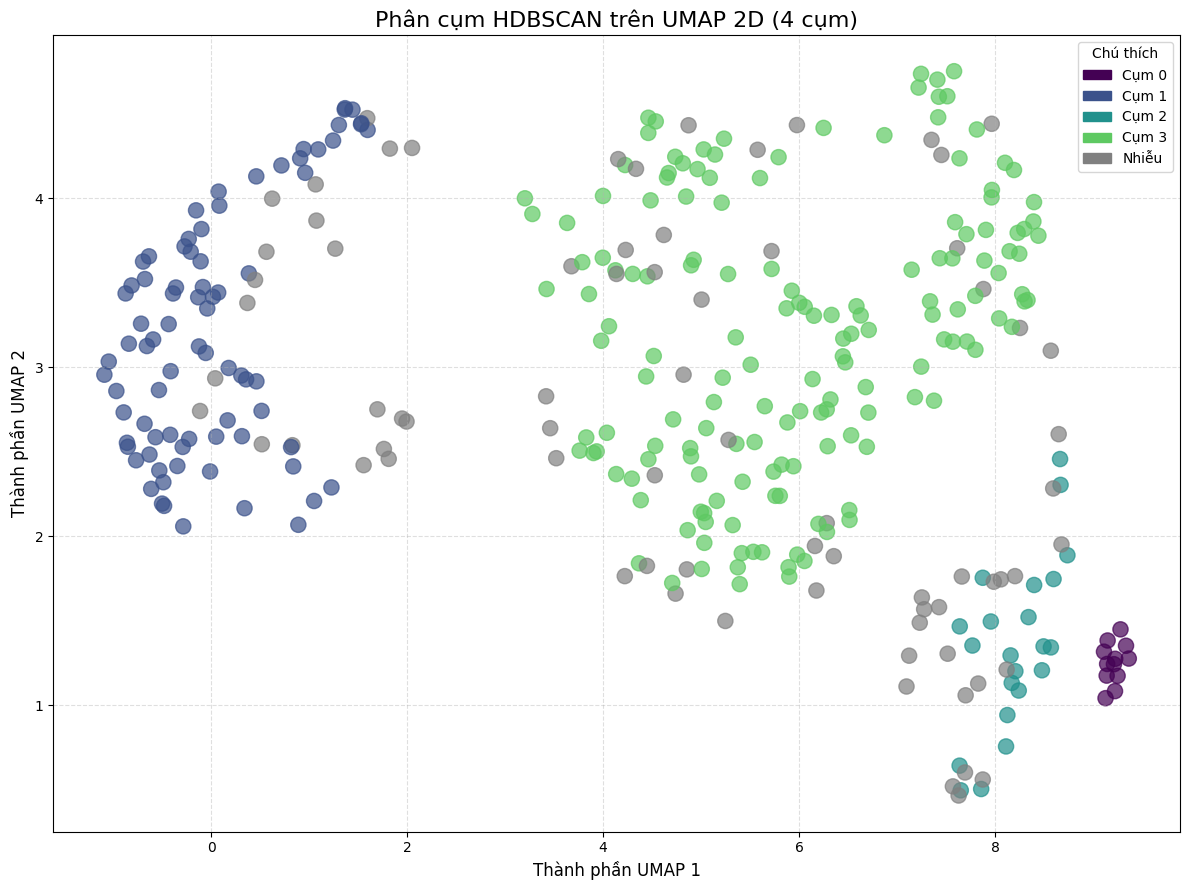

In [ ]:
# Đưa màu theo cụm vào trực quan df_preprocess lên mặt phẳng 2D (không PCA/UMAP lần 2)
unique_labels = set(labels)
colors = plt.cm.get_cmap('viridis', len(unique_labels))

# Tạo danh sách màu cho mỗi điểm dữ liệu
# Nếu nhãn là -1 (nhiễu), tô màu đen nhạt. Ngược lại, tô màu theo cụm.
point_colors = []
for label in labels:
    if label == -1:
        point_colors.append((0.5, 0.5, 0.5, 1.0))  # Màu đen nhạt (RGBA)
    else:
        point_colors.append(colors(label))


print("Đang trực quan hóa kết quả HDBSCAN trên PCA...")

plt.figure(figsize=(10, 8))
plt.scatter(
    data_pca_2d[:, 0],
    data_pca_2d[:, 1],
    c=point_colors,
    s=120,
    alpha=0.7
)

plt.title(f"Phân cụm HDBSCAN trên PCA 2D ({n_clusters} cụm)", fontsize=16)
plt.xlabel("Thành phần chính 1 (PCA 1)", fontsize=12)
plt.ylabel("Thành phần chính 2 (PCA 2)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

import matplotlib.patches as mpatches
cluster_handles = [mpatches.Patch(color=colors(i), label=f'Cụm {i}') for i in range(n_clusters)]
noise_handle = mpatches.Patch(color=(0.5, 0.5, 0.5), label='Nhiễu')
plt.legend(handles=[*cluster_handles, noise_handle], title="Chú thích")

plt.tight_layout()
plt.show()



print("Đang trực quan hóa kết quả HDBSCAN trên UMAP...")

plt.figure(figsize=(12, 9))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=point_colors,
    s=120,
    alpha=0.7
)
plt.title(f"Phân cụm HDBSCAN trên UMAP 2D ({n_clusters} cụm)", fontsize=16)
plt.xlabel("Thành phần UMAP 1", fontsize=12)
plt.ylabel("Thành phần UMAP 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(handles=[*cluster_handles, noise_handle], title="Chú thích")

plt.tight_layout()
plt.show()